## Cycling Promotion

This notebook explores the promotion of cycling in cities. This may encompass
- Political measures: Support programs, grants, reduced parking spaces in city centers
- Environmental and climate campaigns: campaigns, Events (Stadtradeln, Bikechallenge), “Bike to Work Day”
- Infrastructure: construction of bike paths, bike bridges and tunnels; parking facilities; safety; repair stations/service (i.e., Bike check from University); charging infrastructure for e-bikes; integration into public transport (Bike + Ride)
- Health trends: campaigns, pandemic effects
- Economic factors: rising fuel or public transport prices, economic crises
- Technological developments: advances in e-bike technology, leading to wider adoption

In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from utils.filter import get_daily_counter_site_count, get_normalized_daily_city_count

##### Load Data

In [2]:
data = pd.read_csv("../alle_fahrradzaehler_daten.csv")
data['iso_timestamp'] = pd.to_datetime(data['iso_timestamp'], utc = True, errors='coerce') # Isotimestamp is lokale Zeit und berücksichtigt Sommerzeit
data.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

##### Overview

In [ ]:
# Different cities
cities = data['standort'].unique()
print(f"{len(cities)} Cities with bike counters:")
for city in cities:
    print(city)

19 Cities with bike counters:
Stadt Karlsruhe
Stadt Freiburg
Landeshauptstadt Stuttgart
Stadt Tübingen
Stadt Lörrach
Stadt Heilbronn
Stadt Mannheim
Stadt Kirchheim unter Teck
Stadt Heidelberg
Stadt Offenburg
Stadt Ludwisburg
Stadt Konstanz
Landkreis Böblingen
Ravensburg TWS GmbH and Co KG
Stadt Ulm
Stadtverwaltung Aalen
Stadt Reutlingen
Landratsamt Rems-Murr-Kreis
Stadt Singen


In [ ]:
# Since when are data available for each city?
for city in cities:
    city_data = data[data['standort'] == city]
    start_date = city_data['iso_timestamp'].min().date()
    end_date = city_data['iso_timestamp'].max().date()
    print(f"{city}: from {start_date} to {end_date}")

Stadt Karlsruhe: from 2013-01-01 to 2024-11-29
Stadt Freiburg: from 2013-01-01 to 2024-12-01
Landeshauptstadt Stuttgart: from 2013-01-01 to 2024-12-01
Stadt Tübingen: from 2013-05-14 to 2024-12-01
Stadt Lörrach: from 2013-07-17 to 2024-11-30
Stadt Heilbronn: from 2013-11-18 to 2024-12-01
Stadt Mannheim: from 2014-03-25 to 2024-12-01
Stadt Kirchheim unter Teck: from 2014-04-16 to 2024-11-30
Stadt Heidelberg: from 2014-05-31 to 2024-12-01
Stadt Offenburg: from 2017-07-05 to 2023-03-14
Stadt Ludwisburg: from 2017-09-26 to 2024-12-01
Stadt Konstanz: from 2018-08-06 to 2024-12-01
Landkreis Böblingen: from 2019-05-29 to 2024-12-01
Ravensburg TWS GmbH and Co KG: from 2019-11-27 to 2024-12-01
Stadt Ulm: from 2020-01-16 to 2024-12-01
Stadtverwaltung Aalen: from 2020-12-23 to 2024-12-01
Stadt Reutlingen: from 2021-05-10 to 2024-12-01
Landratsamt Rems-Murr-Kreis: from 2021-09-20 to 2024-12-01
Stadt Singen: from 2022-05-11 to 2024-12-01


In [ ]:
# Remove data before 2014-06-01 and after 2024-05-31
start_date = pd.Timestamp('2014-06-01', tz='UTC')
end_date = pd.Timestamp('2024-05-31', tz='UTC')

data = data[(data['iso_timestamp'] >= start_date) & (data['iso_timestamp'] <= end_date)]

# Remove cities that do not have data for the whole period
valid_cities = []
for city in cities:
    city_data = data[data['standort'] == city]
    city_start_date = city_data['iso_timestamp'].min()
    city_end_date = city_data['iso_timestamp'].max()
    if city_start_date <= start_date and city_end_date >= end_date:
        valid_cities.append(city)
print(f"{len(valid_cities)} Cities with complete data from {start_date.date()} to {end_date.date()}:")
for city in valid_cities:
    print(city)
data = data[data['standort'].isin(valid_cities)]

9 Cities with complete data from 2014-06-01 to 2024-05-31:
Stadt Karlsruhe
Stadt Freiburg
Landeshauptstadt Stuttgart
Stadt Tübingen
Stadt Lörrach
Stadt Heilbronn
Stadt Mannheim
Stadt Kirchheim unter Teck
Stadt Heidelberg


Note: Wenn wir Städte vergleichen, sollte wir auch durch die Einwohnerzahl teilen, außerdem: sollten wir Channel_id oder counter_site verwenden?

##### Tageswerte

In [ ]:
# Tageswert eines Counters
counter_site_id = 100003358
date = "2024-01-01" # YYYY-MM-DD

daily_count, _ = get_daily_counter_site_count(data, counter_site_id, date)
print(f"Tageswert für Zählstelle {counter_site_id} am {date}: {daily_count}")

Tageswert für Zählstelle 100003358 am 2024-01-01: 4978


In [ ]:
# Tageswert eines Standorts
standort = "Stadt Tübingen"
date = "2024-01-01" # YYYY-MM-DD

normalized_tageswert, num_active_sites, total_daily_counts = get_normalized_daily_city_count(data, standort, date)
print(f"Normalisierter Tageswert für Standort {standort} am {date}: {normalized_tageswert} (basierend auf {num_active_sites} aktiven Zählstellen mit insgesamt {total_daily_counts} gezählten Fahrrädern)")

Normalisierter Tageswert für Standort Stadt Tübingen am 2024-01-01: 2267.0 (basierend auf 3 aktiven Zählstellen mit insgesamt 6801 gezählten Fahrrädern)


In [ ]:
# Jahreswert für einen Standort
standort = "Stadt Tübingen"
year = 2023

def calculate_annual_count(df, standort, year):
    """
    Berechnet den Jahres-Fahrrad-Count für einen bestimmten Standort und ein Jahr 
    gemäß der Regel: (zählstand pro Stunde) / (Anzahl der aktiven Kanäle pro Stunde).

    Args:
        df (pd.DataFrame): Das Datenset.
        location (str): Der Wert in der Spalte 'standort' (z.B. 'Stadt Tübingen').
        year (int): Das gewünschte Jahr (z.B. 2023).

    Returns:
        float: Der berechnete Jahres-Gesamt-Count.
    """
    
    # 1. Filtern nach Standort
    df_loc = df[df['standort'] == standort].copy()
    
    if df_loc.empty:
        return 0.0

    # 2. Filtern nach Jahr
    df_year = df_loc[df_loc['iso_timestamp'].dt.year == year].copy()
    
    if df_year.empty:
        return 0.0

    # 3. Anzahl der aktiven Kanäle ('channel_id') pro Zeitstempel (Stunde) berechnen
    channel_counts = df_year.groupby('iso_timestamp')['channel_id'].nunique().reset_index()
    channel_counts.columns = ['iso_timestamp', 'num_channels']

    # 4. Anzahl der Kanäle zum Haupt-DataFrame hinzufügen
    df_merged = pd.merge(df_year, channel_counts, on='iso_timestamp')

    # 5. Berechnen des angepassten Zählwerts: zählstand / num_channels
    df_merged.loc[:, 'adjusted_count'] = df_merged['zählstand'] / df_merged['num_channels']

    # 6. Summe des angepassten Zählwerts für den Jahres-Gesamt-Count
    total_count = df_merged['adjusted_count'].sum()
    
    return total_count

annual_count = calculate_annual_count(data, standort, year)
print(f"Jahreswert für Standort {standort} im Jahr {year}: {annual_count}")

# Erstelle ein df mit Jahreswerten für alle Städte
data['year'] = data['iso_timestamp'].dt.year
unique_combinations = data.groupby(['standort', 'year']).size().reset_index()[['standort', 'year']]
annual_counts = []
for index, row in unique_combinations.iterrows():
    city = row['standort']
    yr = row['year']
    count = calculate_annual_count(data, city, yr)
    annual_counts.append({'standort': city, 'year': yr, 'annual_count': count})
annual_counts_df = pd.DataFrame(annual_counts)

annual_counts_df.head()

# Entferne Jahre außerhalb 2015-2023, da unvollständige Daten für 2014 und 2024
annual_counts_df = annual_counts_df[(annual_counts_df['year'] >= 2015) & (annual_counts_df['year'] <= 2023)]
     

Jahreswert für Standort Stadt Tübingen im Jahr 2023: 249514.05555555556


In [ ]:
annual_counts_df

,standort,year,annual_count
1,Landeshauptstadt Stuttgart,2015,132445.250000
2,Landeshauptstadt Stuttgart,2016,129587.125000
3,Landeshauptstadt Stuttgart,2017,102405.750000
4,Landeshauptstadt Stuttgart,2018,125637.000000
5,Landeshauptstadt Stuttgart,2019,128210.083333
...,...,...,...
93,Stadt Tübingen,2019,690635.833333
94,Stadt Tübingen,2020,612100.111111
95,Stadt Tübingen,2021,206224.000000
96,Stadt Tübingen,2022,245514.722222


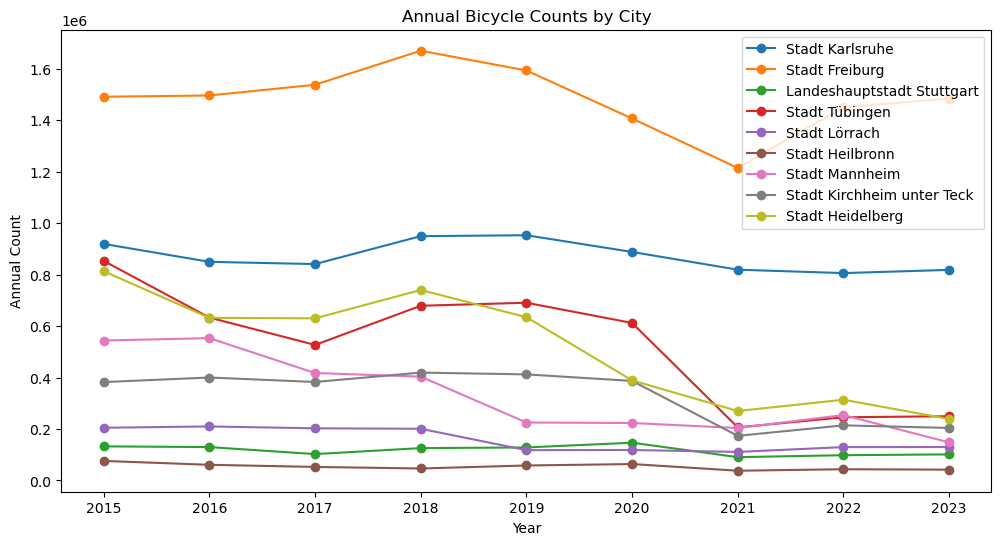

In [ ]:
# Plotte Jahreswerte für alle Städte
plt.figure(figsize=(12, 6))

for city in valid_cities:
    city_data = annual_counts_df[annual_counts_df['standort'] == city]
    plt.plot(city_data['year'], city_data['annual_count'], marker='o', label=city)
plt.xlabel('Year')
plt.ylabel('Annual Count')
plt.title('Annual Bicycle Counts by City')
plt.legend()
plt.show()

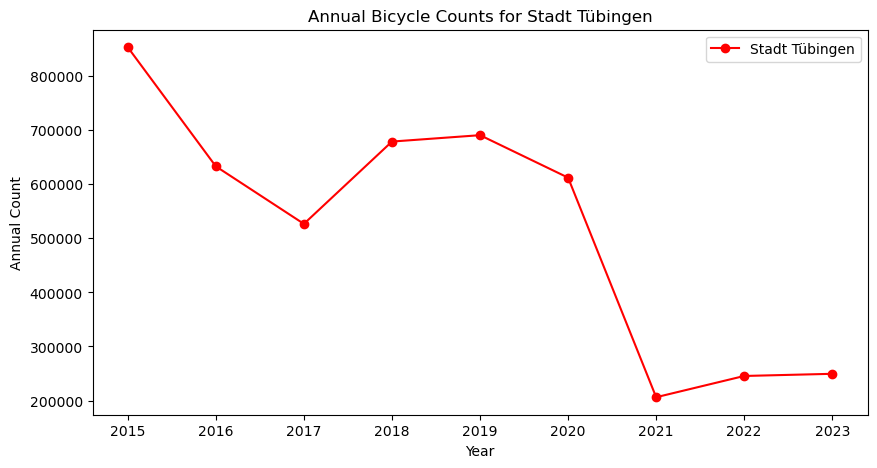

In [ ]:
# Plotte nur Tübingen
plt.figure(figsize=(10, 5))
city = "Stadt Tübingen"
city_data = annual_counts_df[annual_counts_df['standort'] == city]
plt.plot(city_data['year'], city_data['annual_count'], marker='o', label=city, color='red')
plt.xlabel('Year')
plt.ylabel('Annual Count')
plt.title(f'Annual Bicycle Counts for {city}')
plt.legend()
plt.show()

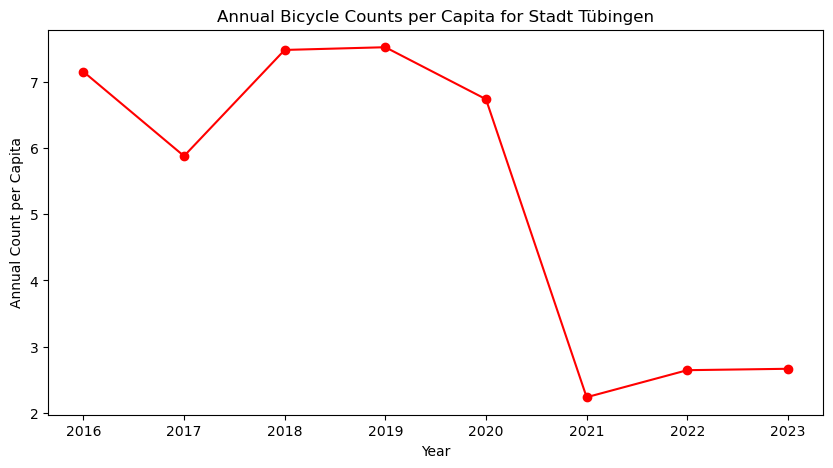

In [ ]:
# Einwohnerzahlen Tübingen seit 2016:
# Teile Jahreswerte durch Einwohnerzahlen
einwohnerzahlen_tuebingen = {2016: 88526, 2017: 89610, 2018: 90764, 2019: 91839, 2020: 90877, 2021: 92170, 2022: 92800, 2023: 93567, 2024: 94274}
tuebingen_data = annual_counts_df[annual_counts_df['standort'] == "Stadt Tübingen"].copy()
tuebingen_data['annual_count_per_capita'] = tuebingen_data.apply(lambda row: row['annual_count'] / einwohnerzahlen_tuebingen.get(row['year'], 1), axis=1)
tuebingen_data = tuebingen_data[tuebingen_data['year'] >= 2016].copy()
# Plotte Jahreswerte pro Einwohner für Tübingen ab 2016
plt.figure(figsize=(10, 5))
plt.plot(tuebingen_data['year'], tuebingen_data['annual_count_per_capita'], marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('Annual Count per Capita')
plt.title('Annual Bicycle Counts per Capita for Stadt Tübingen')
plt.show()

##### Fahrradbrücken Tübingen

In [ ]:
# List alle Zählstellen eines standorts auf
stadt = "Stadt Tübingen"
zaehlstellen = data[data['standort'] == stadt]['counter_site_id'].unique()
print(f"{len(zaehlstellen)} Zählstellen in {stadt}:")
for zaehlstelle in zaehlstellen:
    name = data[data['counter_site_id'] == zaehlstelle]['counter_site'].iloc[0]
    print(f"Zählstelle {zaehlstelle}: {name}")

3 Zählstellen in Stadt Tübingen:
Zählstelle 100003358: Fuß- & Radtunnel Südportal - Derendinger Allee
Zählstelle 100003359: Unterführung Steinlach/Karlstraße Südseite - Steinlachallee
Zählstelle 100026408: Neckartalradweg Hirschau - parallel L371
